In [1]:
from __future__ import annotations

from typing import  List
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: C:\Users\markm\Documents\programming\Flexible-Cloud-Resource\analysis


In [2]:
from src.extra.visualise import plot_allocation_results, ImageFormat, minimise_resource_allocation
from src.core.core import reset_model
from src.core.fixed_task import FixedTask, SumSpeedsFixedPolicy
from src.core.server import Server
from src.core.task import Task
from src.greedy.greedy import greedy_algorithm
from src.greedy.resource_allocation_policy import SumPowPercentage
from src.greedy.server_selection_policy import ProductResources
from src.greedy.value_density import UtilityDeadlinePerResource
from src.optimal.fixed_optimal import fixed_optimal
from src.optimal.flexible_optimal import flexible_optimal

In [3]:
tasks = [
    Task("Task 1",  required_storage=100, required_computation=100, required_results_data=50, deadline=10, value=100),
    Task("Task 2",  required_storage=75,  required_computation=125, required_results_data=40, deadline=10, value=90),
    Task("Task 3",  required_storage=125, required_computation=110, required_results_data=45, deadline=10, value=110),
    Task("Task 4",  required_storage=100, required_computation=75,  required_results_data=60, deadline=10, value=75),
    Task("Task 5",  required_storage=85,  required_computation=90,  required_results_data=55, deadline=10, value=125),
    Task("Task 6",  required_storage=75,  required_computation=120, required_results_data=40, deadline=10, value=100),
    Task("Task 7",  required_storage=125, required_computation=100, required_results_data=50, deadline=10, value=80),
    Task("Task 8",  required_storage=115, required_computation=75,  required_results_data=55, deadline=10, value=110),
    Task("Task 9",  required_storage=100, required_computation=110, required_results_data=60, deadline=10, value=120),
    Task("Task 10", required_storage=90,  required_computation=120, required_results_data=40, deadline=10, value=90),
    Task("Task 11", required_storage=110, required_computation=90,  required_results_data=45, deadline=10, value=100),
    Task("Task 12", required_storage=100, required_computation=80,  required_results_data=55, deadline=10, value=100)
]

servers = [
    Server("Server 1", storage_capacity=500, computation_capacity=95, bandwidth_capacity=220),
    Server("Server 2", storage_capacity=500, computation_capacity=95, bandwidth_capacity=210),
    Server("Server 3", storage_capacity=500, computation_capacity=90, bandwidth_capacity=250)
]

In [4]:
def print_tasks(tasks: List[Task]):
    print(f'Social welfare: {sum(task.value for task in tasks if task.running_server)}, '
          f'percentage tasks allocated: {sum(task.running_server is not None for task in tasks)}')
    max_task_name_len = max(len(task.name) for task in tasks) + 1
    print("{:<{}}| Value |{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}| {}"
          .format("Name", max_task_name_len, "Storage", "Computation", "Results", "Deadline", 
                  "Loading", "Compute", "Sending", "Server"))
    
    for task in tasks:
        print("{:<{name_len}}|{:^7.1f}|{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}|{:^10}"
              .format(task.name, task.value, task.required_storage, task.required_computation, task.required_results_data,
                      task.deadline, task.loading_speed, task.compute_speed, task.sending_speed,
                      task.running_server.name if task.running_server else "None", name_len=max_task_name_len))

### Optimal Solution

Social welfare: 1200, percentage tasks allocated: 12
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   34    |   22    |   20    | Server 2 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   29    |   25    |   17    | Server 1 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   40    |   22    |   24    | Server 3 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   28    |   20    |   23    | Server 1 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   33    |   16    |   31    | Server 1 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   26    |   24    |   19    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   41    |   21    |   23    | Server 3 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   35    |   17    |   24    | Server 3 
Task 9  | 120.0 |   100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/example_allocation/pdf/optimal_flexible_resource_allocation.pdf


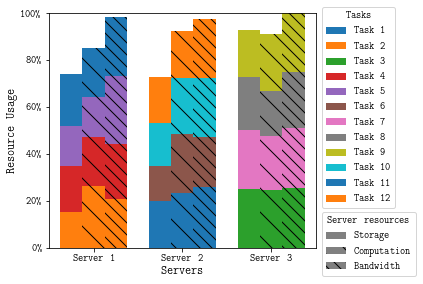

In [5]:
optimal_results = flexible_optimal(tasks, servers, time_limit=5)
minimise_resource_allocation(tasks, servers)

print_tasks(tasks)
plot_allocation_results(tasks, servers, "Optimal Flexible Resource Allocation")
reset_model(tasks, servers)

### Fixed Solution

Social welfare: 955, percentage tasks allocated: 9
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   24    |   30    |   20    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   23    |   27    |   19    |   None   
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   35    |   28    |   18    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   25    |   25    |   20    |   None   
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   21    |   27    |   21    | Server 3 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   20    |   29    |   19    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   33    |   28    |   19    |   None   
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   30    |   22    |   20    | Server 2 
Task 9  | 120.0 |   100  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/example_allocation/eps/optimal_fixed_resource_allocation.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/example_allocation/pdf/optimal_fixed_resource_allocation.pdf


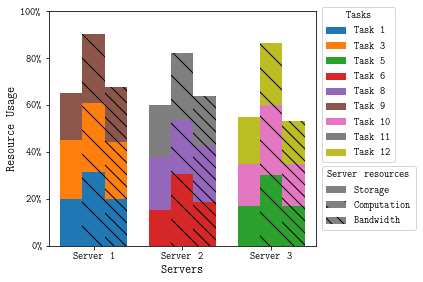

In [6]:
fixed_tasks = [FixedTask(task, SumSpeedsFixedPolicy(), fixed_name=False) for task in tasks]
fixed_results = fixed_optimal(fixed_tasks, servers, time_limit=5)

print_tasks(fixed_tasks)
plot_allocation_results(fixed_tasks, servers, "Optimal Fixed Resource Allocation")
reset_model(tasks, servers)

### Greedy Solution

Social welfare: 1200, percentage tasks allocated: 12
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   32    |   23    |   20    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   30    |   22    |   22    | Server 3 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   33    |   26    |   23    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   30    |   18    |   24    | Server 3 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   26    |   21    |   23    | Server 2 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   25    |   24    |   20    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   42    |   20    |   25    | Server 3 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   32    |   20    |   21    | Server 2 
Task 9  | 120.0 |   100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/example_allocation/pdf/greedy_flexible_resource_allocation.pdf


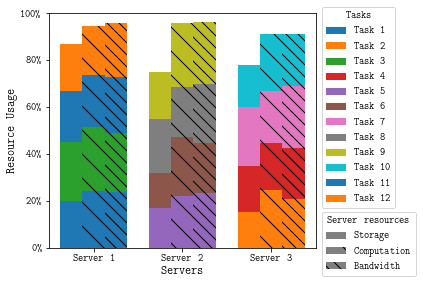

In [7]:
greedy_results = greedy_algorithm(tasks, servers, UtilityDeadlinePerResource(), ProductResources(), SumPowPercentage())

print_tasks(tasks)
plot_allocation_results(tasks, servers, "Greedy Flexible Resource Allocation")
reset_model(tasks, servers)

### Optimal, Fixed and Greedy results

In [8]:
"""results = {'Optimal': optimal_results, 'Fixed': fixed_results, 'Greedy': greedy_results}

max_name_len = max(len(name) for name in results.keys())
max_storage_len = max(len(str(list(result.server_storage_used.values()))) for result in results.values())
max_computation_len = max(len(str(list(result.server_computation_used.values()))) for result in results.values())
max_bandwidth_len = max(len(str(list(result.server_bandwidth_used.values()))) for result in results.values())

print(f"{'Name':<{max_name_len}} | Social Welfare | {'Storage':^{max_storage_len}} | {'Computation':^{max_computation_len}} | "
      f"{'Bandwidth':^{max_bandwidth_len}} | Num Jobs")
for name, result in results.items():
    print(f"{name:<{max_name_len}} | {result.social_welfare:^5} | "
          f"{str(list(result.server_storage_used.values())):^{max_storage_len}} | "
          f"{str(list(result.server_computation_used.values())):^{max_computation_len}} | "
          f"{str(list(result.server_bandwidth_used.values())):^{max_bandwidth_len}} | "
          f"{str(list(result.server_num_tasks_allocated.values()))}")"""

'results = {\'Optimal\': optimal_results, \'Fixed\': fixed_results, \'Greedy\': greedy_results}\n\nmax_name_len = max(len(name) for name in results.keys())\nmax_storage_len = max(len(str(list(result.server_storage_used.values()))) for result in results.values())\nmax_computation_len = max(len(str(list(result.server_computation_used.values()))) for result in results.values())\nmax_bandwidth_len = max(len(str(list(result.server_bandwidth_used.values()))) for result in results.values())\n\nprint(f"{\'Name\':<{max_name_len}} | Social Welfare | {\'Storage\':^{max_storage_len}} | {\'Computation\':^{max_computation_len}} | "\n      f"{\'Bandwidth\':^{max_bandwidth_len}} | Num Jobs")\nfor name, result in results.items():\n    print(f"{name:<{max_name_len}} | {result.social_welfare:^5} | "\n          f"{str(list(result.server_storage_used.values())):^{max_storage_len}} | "\n          f"{str(list(result.server_computation_used.values())):^{max_computation_len}} | "\n          f"{str(list(result.

## Model to latex converter

In [9]:
for task in fixed_tasks:
    print(f'{task.name} & {task.value} & {task.required_storage} & {task.required_computation} & '
          f'{task.required_results_data} & {task.deadline} & {task.loading_speed} & {task.compute_speed} & '
          f'{task.sending_speed} \\\\ \\hline')
print('')
for server in servers:    
    print(f'{server.name} & {server.storage_capacity} & {server.computation_capacity} & {server.bandwidth_capacity} \\\\ \\hline')

Task 1 & 100 & 100 & 100 & 50 & 10 & 24 & 30 & 20 \\ \hline
Task 2 & 90 & 75 & 125 & 40 & 10 & 23 & 27 & 19 \\ \hline
Task 3 & 110 & 125 & 110 & 45 & 10 & 35 & 28 & 18 \\ \hline
Task 4 & 75 & 100 & 75 & 60 & 10 & 25 & 25 & 20 \\ \hline
Task 5 & 125 & 85 & 90 & 55 & 10 & 21 & 27 & 21 \\ \hline
Task 6 & 100 & 75 & 120 & 40 & 10 & 20 & 29 & 19 \\ \hline
Task 7 & 80 & 125 & 100 & 50 & 10 & 33 & 28 & 19 \\ \hline
Task 8 & 110 & 115 & 75 & 55 & 10 & 30 & 22 & 20 \\ \hline
Task 9 & 120 & 100 & 110 & 60 & 10 & 30 & 28 & 22 \\ \hline
Task 10 & 90 & 90 & 120 & 40 & 10 & 27 & 27 & 18 \\ \hline
Task 11 & 100 & 110 & 90 & 45 & 10 & 25 & 27 & 20 \\ \hline
Task 12 & 100 & 100 & 80 & 55 & 10 & 24 & 24 & 22 \\ \hline

Server 1 & 500 & 95 & 220 \\ \hline
Server 2 & 500 & 95 & 210 \\ \hline
Server 3 & 500 & 90 & 250 \\ \hline
